# Crop Recommendation System using Deep Learning
This notebook implements a deep learning model to recommend suitable crops based on soil and climate conditions.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.utils.class_weight import compute_class_weight

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load and Preprocess Data

In [4]:
# Load the dataset
df = pd.read_csv('agro_dataset_with_rules.csv')

# Separate features and target
X = df.drop(['crop', 'field_id', 'start_month', 'end_month'], axis=1)
y = df['crop']

categorical_cols = ['last_crop']
X = pd.get_dummies(X, columns=categorical_cols)

numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'pH', 'rainfall', 'duration_months', 'last_crop_duration']

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

ct = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols)
], remainder='passthrough')
X_scaled = ct.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

## 2. Data Visualization
### 2.1 Crop Distribution

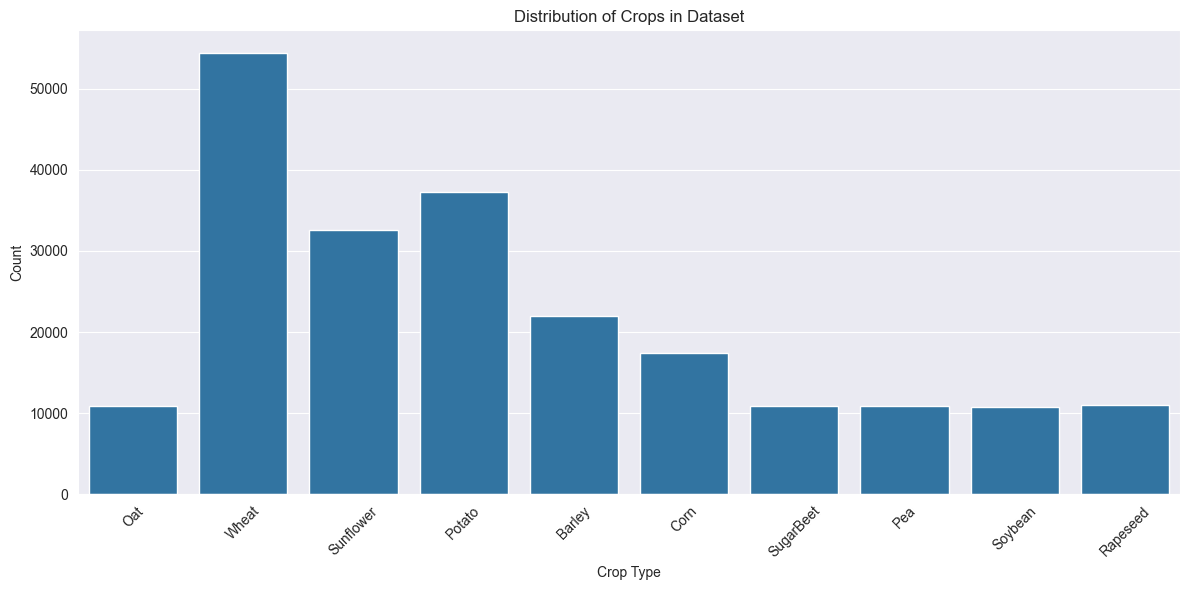

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='crop')
plt.xticks(rotation=45)
plt.title('Distribution of Crops in Dataset')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 2.2 Feature Correlation Heatmap

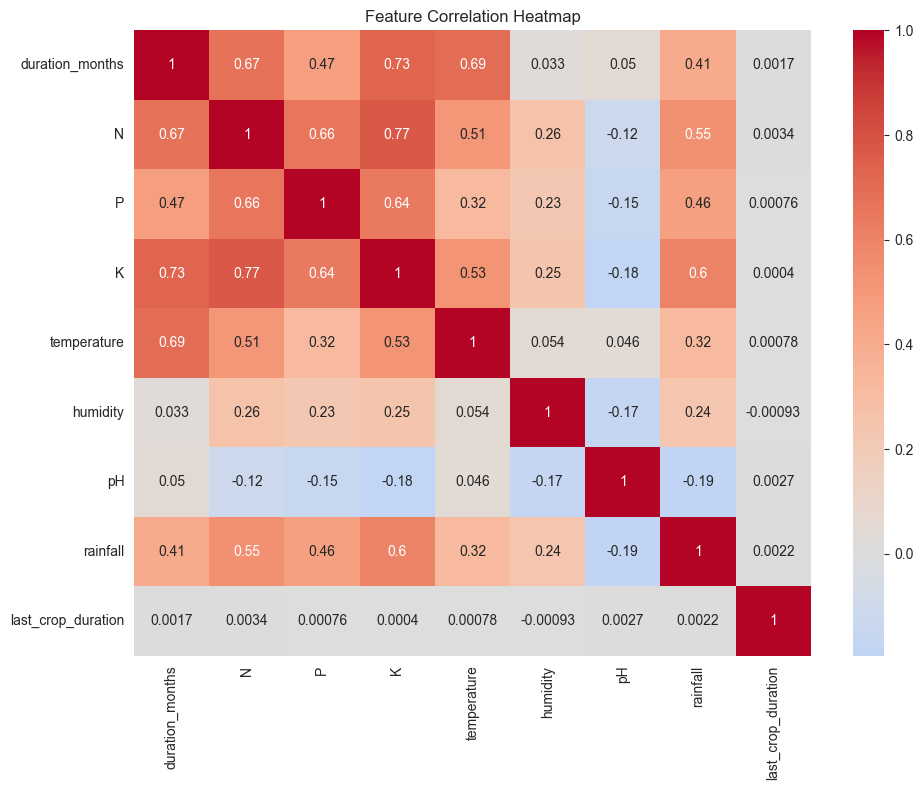

In [6]:
# Get only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 3. Model Development

In [7]:
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.1),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model


input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = create_model((X_train.shape[1],), len(np.unique(y)))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1, class_weight=class_weight_dict)

Epoch 1/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8212 - loss: 0.5146 - val_accuracy: 0.8419 - val_loss: 0.3942
Epoch 2/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8466 - loss: 0.4243 - val_accuracy: 0.8625 - val_loss: 0.3360
Epoch 3/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8531 - loss: 0.3933 - val_accuracy: 0.8487 - val_loss: 0.3469
Epoch 4/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8570 - loss: 0.3782 - val_accuracy: 0.8561 - val_loss: 0.3321
Epoch 5/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8578 - loss: 0.3673 - val_accuracy: 0.8664 - val_loss: 0.3026
Epoch 6/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8584 - loss: 0.3587 - val_accuracy: 0.8650 - val_loss: 0.3008
Epoch 7/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8601 - loss: 0.3533 - val_accuracy: 0.8594 - val_loss: 0.3282
Epoch 8/50
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8616 - loss: 0

### 3.1 Training History Visualization

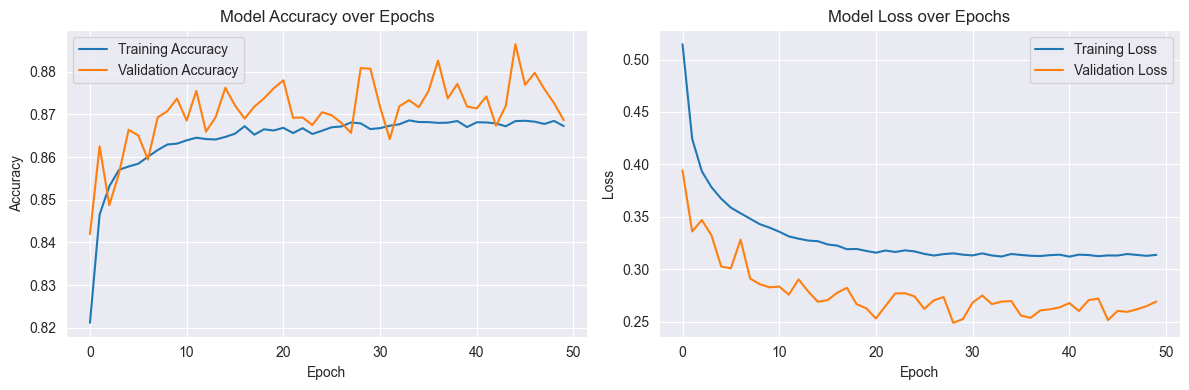

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Model Evaluation

1364/1364 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step
Accuracy: 0.8663
Precision: 0.9168
Recall: 0.8663

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      4379
           1       0.96      0.91      0.93      3492
           2       0.82      0.70      0.76      2097
           3       0.59      0.92      0.72      2114
           4       1.00      0.91      0.95      7606
           5       0.45      1.00      0.62      2283
           6       0.73      1.00      0.84      2056
           7       0.87      0.95      0.91      2275
           8       1.00      1.00      1.00      6361
           9       1.00      0.74      0.85     10958

    accuracy                           0.87     43621
   macro avg       0.84      0.89      0.84     43621
weighted avg       0.92      0.87      0.88     43621



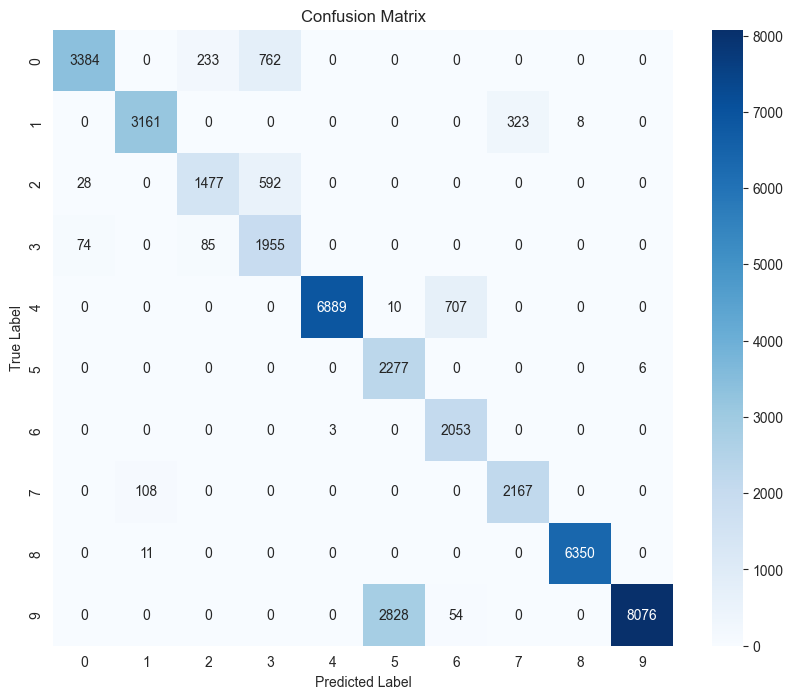

In [9]:
# Add these imports at the beginning of your notebook
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Generate predictions using your model
y_pred = model.predict(X_test)

# Convert predictions to class labels if they're probabilities
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)

# Ensure both are 1D arrays
y_test = np.array(y_test).ravel()
y_pred = np.array(y_pred).ravel()

# Now calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

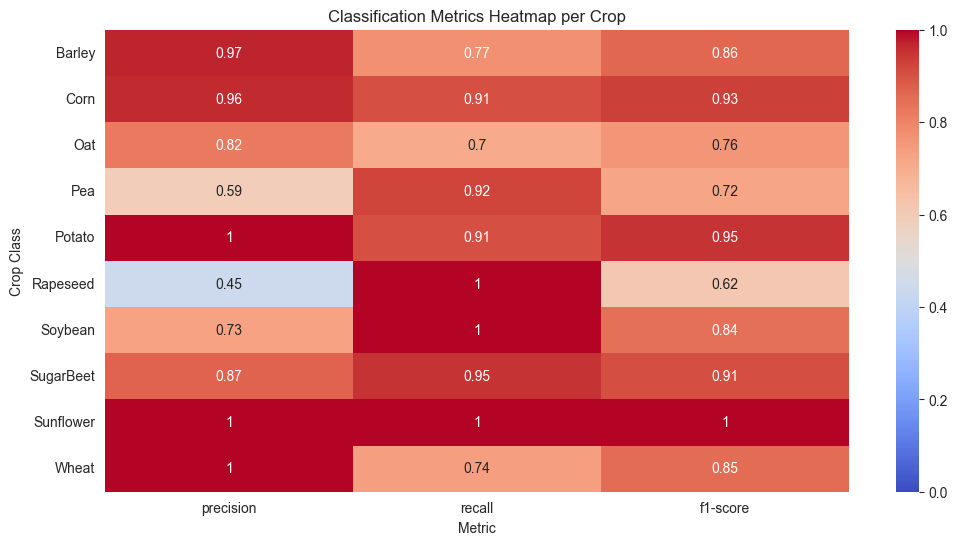

In [10]:
crop_names = le.classes_
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
metrics_df = report_df[['precision', 'recall', 'f1-score']].iloc[:-3]
metrics_df.index = crop_names

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Classification Metrics Heatmap per Crop')
plt.ylabel('Crop Class')
plt.xlabel('Metric')
plt.show()

## 5. Save the Model

In [11]:
# Save the model
model.save('crop_recommendation_model.keras')

# Save the scaler and label encoder
import joblib

joblib.dump(ct, 'column_transformer.joblib')
joblib.dump(le, 'label_encoder.joblib')

last_crop_categories = [col for col in X.columns if col.startswith('last_crop_')]
joblib.dump(last_crop_categories, 'last_crop_categories.joblib')

['last_crop_categories.joblib']